In [1]:
import pandas as pd
import censusdata
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sb
from scipy.interpolate import UnivariateSpline

%matplotlib inline
%config InlineBackend.figure_format ='retina'

sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

In [2]:
gdf = pd.read_pickle(sharedFolder + "gdf2020.pkl")
gdf = gdf[['CBSA', 'NAME', 'metro', 'micro', 'liminal', 'geometry']]
gdf

,CBSA,NAME,metro,micro,liminal,geometry
0,10180,"Abilene, TX",False,False,False,"POLYGON ((-11148262.500 3832132.455, -11148249..."
1,10420,"Akron, OH",False,False,False,"POLYGON ((-9060481.928 5063847.837, -9060475.5..."
2,10500,"Albany, GA",False,False,False,"POLYGON ((-9400975.184 3713776.408, -9400980.6..."
3,10540,"Albany-Lebanon, OR",False,False,False,"POLYGON ((-13720236.776 5551262.937, -13720393..."
4,10580,"Albany-Schenectady-Troy, NY",False,False,False,"POLYGON ((-8247992.807 5305256.748, -8248085.6..."
...,...,...,...,...,...,...
921,49300,"Wooster, OH",False,False,False,"POLYGON ((-9089178.853 5010653.858, -9088979.1..."
922,49380,"Worthington, MN",False,True,False,"POLYGON ((-10627927.538 5441934.306, -10627791..."
923,49460,"Yankton, SD",False,True,False,"POLYGON ((-10855702.126 5337734.746, -10853435..."
924,49780,"Zanesville, OH",False,True,True,"POLYGON ((-9149881.580 4868949.855, -9149879.9..."


In [3]:
mig = gpd.GeoDataFrame(pd.read_pickle(dataFolder + '2010-2022_net_migration.pkl')).reset_index()

mig = mig.reset_index().rename(columns={
    'cbsa': 'CBSA',
    'NATURALCHG2021': 'NATURALINC2021',
    'RNATURALCHG2021': 'RNATURALINC2021',
    'NATURALCHG2022': 'NATURALINC2022',
    'RNATURALCHG2022': 'RNATURALINC2022'
}).drop(columns=[
    'STNAME', 'CTYNAME', 'CENSUS2010POP' #CENSUS2010POP is a string??
])

mig = pd.merge(mig, gdf, on='CBSA')
mig

,index,CBSA,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,...,RINTERNATIONALMIG2022,RDOMESTICMIG2021,RDOMESTICMIG2022,RNETMIG2021,RNETMIG2022,NAME,metro,micro,liminal,geometry
0,0,10100,40603,40721,40974,41591,42175,42250,42432,42821,...,2.726604,3.541333,-0.552677,4.689007,2.173927,"Aberdeen, SD",False,True,False,"POLYGON ((-10989736.448 5659978.604, -10990063..."
1,1,10140,72800,72849,72374,71785,71059,70796,71027,71555,...,0.234032,17.452602,8.633187,17.596730,8.867219,"Aberdeen, WA",False,True,True,"POLYGON ((-13837615.681 5982098.516, -13837721..."
2,2,10180,165252,165590,166651,167483,167515,168408,169770,170087,...,1.110819,16.400186,11.060707,16.792486,12.171526,"Abilene, TX",False,False,False,"POLYGON ((-11148262.500 3832132.455, -11148249..."
3,3,10220,37488,37594,37751,38064,38162,38292,38343,38499,...,0.288200,3.093784,-0.078600,3.172439,0.209600,"Ada, OK",False,True,True,"POLYGON ((-10790478.575 4120536.368, -10790479..."
4,4,10300,99898,99642,99370,99041,98850,98774,98432,98595,...,1.001168,0.795882,-4.267605,1.158562,-3.266437,"Adrian, MI",False,True,True,"POLYGON ((-9391131.716 5145826.837, -9391131.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,917,49660,565782,564760,562339,558594,555998,553267,549114,544768,...,0.397572,1.383251,1.938198,1.522834,2.335771,"Youngstown-Warren-Boardman, OH-PA",False,False,False,"POLYGON ((-9017133.666 5032154.477, -9017136.6..."
917,918,49700,166893,167087,166946,166923,167539,168248,169263,170689,...,1.592813,1.652994,-1.889841,2.257712,-0.297028,"Yuba City, CA",False,False,False,"POLYGON ((-13539095.212 4764106.072, -13539054..."
918,919,49740,195750,197148,202881,202520,202447,204064,205187,207162,...,6.167846,3.335208,-1.618033,5.511614,4.549812,"Yuma, AZ",False,False,False,"POLYGON ((-12775445.758 3848066.261, -12775405..."
919,920,49780,86086,86213,86252,85803,85660,85918,86213,85958,...,0.115816,2.647032,-2.629034,2.716386,-2.513218,"Zanesville, OH",False,True,True,"POLYGON ((-9149881.580 4868949.855, -9149879.9..."


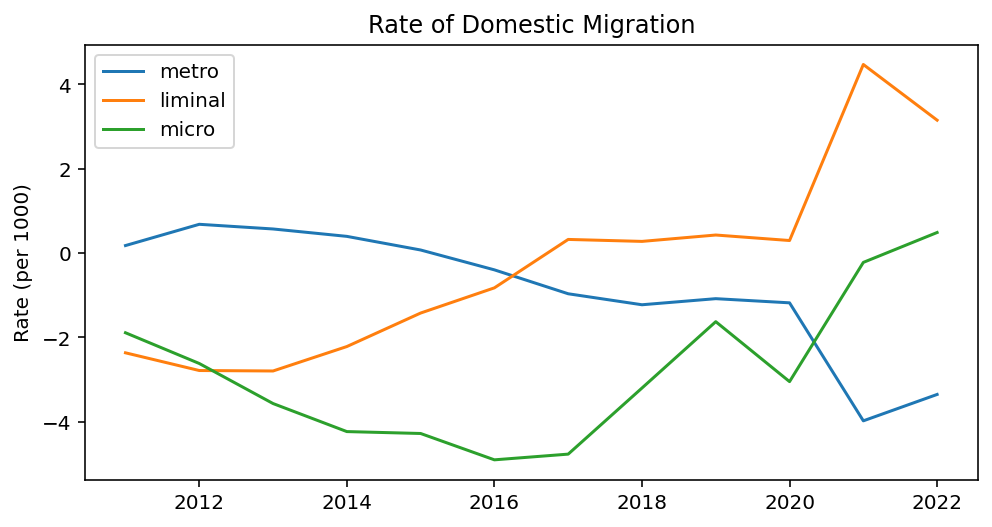

In [4]:
liminal = mig['liminal']
metro = mig['metro']
micro = mig['micro']
notLim = mig['micro'] & ~liminal
other = ~metro & ~micro

df = pd.DataFrame()
for year in range(2011, 2022 + 1):
    df.loc[year, 'metro'] =   mig[metro  ]['DOMESTICMIG%i' % year].sum() / (mig[metro  ]['POPESTIMATE%i' % (year-1)].sum() + mig[metro  ]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'liminal'] = mig[liminal]['DOMESTICMIG%i' % year].sum() / (mig[liminal]['POPESTIMATE%i' % (year-1)].sum() + mig[liminal]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'micro'] =   mig[notLim ]['DOMESTICMIG%i' % year].sum() / (mig[notLim ]['POPESTIMATE%i' % (year-1)].sum() + mig[notLim ]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    # df.loc[year, 'other'] =   mig[other  ]['DOMESTICMIG%i' % year].sum() / (mig[other  ]['POPESTIMATE%i' % (year-1)].sum() + mig[other  ]['POPESTIMATE%i' % year].sum()) * 2 * 1000

df.plot(figsize=(8, 4));
plt.ylabel("Rate (per 1000)")
plt.title("Rate of Domestic Migration");

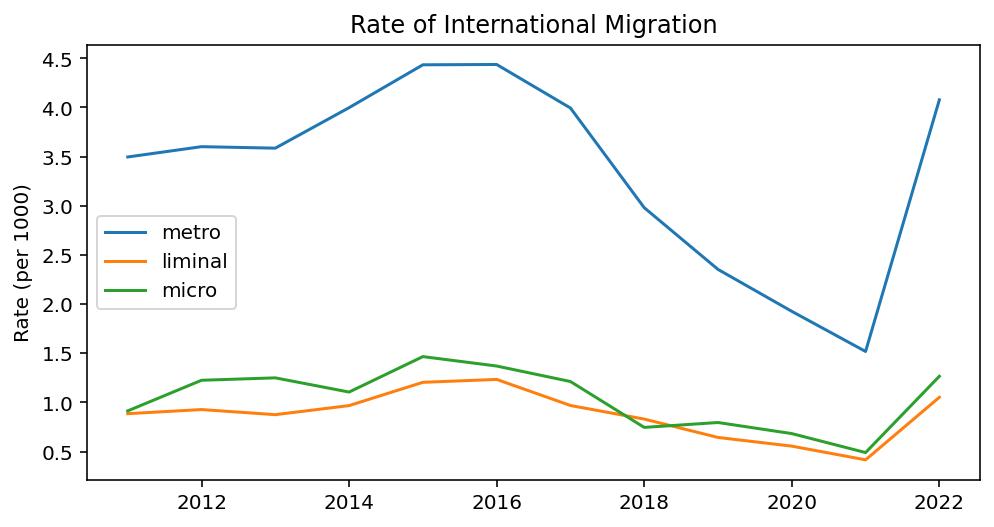

In [5]:
liminal = mig['liminal']
metro = mig['metro']
micro = mig['micro']
notLim = mig['micro'] & ~liminal

df = pd.DataFrame()
for year in range(2011, 2022 + 1):
    df.loc[year, 'metro'] =   mig[metro  ]['INTERNATIONALMIG%i' % year].sum() / (mig[metro  ]['POPESTIMATE%i' % (year-1)].sum() + mig[metro  ]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'liminal'] = mig[liminal]['INTERNATIONALMIG%i' % year].sum() / (mig[liminal]['POPESTIMATE%i' % (year-1)].sum() + mig[liminal]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'micro'] =   mig[notLim ]['INTERNATIONALMIG%i' % year].sum() / (mig[notLim ]['POPESTIMATE%i' % (year-1)].sum() + mig[notLim ]['POPESTIMATE%i' % year].sum()) * 2 * 1000

df.plot(figsize=(8, 4));
plt.ylabel("Rate (per 1000)")
plt.title("Rate of International Migration");

In [6]:
mig['RDOMESTICMIG2021w'] = mig['DOMESTICMIG2021'] / (mig['POPESTIMATE2020'] + mig['POPESTIMATE2021']) * 2 * 1000
mig[liminal].sort_values('RDOMESTICMIG2021w')[['NAME', 'CBSA', 'DOMESTICMIG2021', 'RDOMESTICMIG2021w', 'POPESTIMATE2021']]

,NAME,CBSA,DOMESTICMIG2021,RDOMESTICMIG2021w,POPESTIMATE2021
647,"Pearsall, TX",37770,-912,-48.092388,17548
41,"Athens, OH",11900,-2984,-47.909960,59086
534,"Menomonie, WI",32860,-929,-20.653394,44509
233,"DuBois, PA",20180,-1567,-19.968779,78333
164,"Clarksdale, MS",17260,-399,-18.867032,20732
...,...,...,...,...,...
712,"Rockport, TX",40530,893,36.951979,24519
635,"Pahrump, NV",37220,2105,41.547009,53277
326,"Granbury, TX",24180,2731,42.741999,64263
618,"Oneonta, NY",36580,2735,45.789769,60758
